Import library


*   Numpy
*   Pandas
*   Tensorflow
*   Sklearn



In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, classification_report

Reading data from CSV and split into train and val with 80:20 ratio

In [14]:
df = pd.read_csv('Stunting Datasets.csv', delimiter=';')
# df_1 = pd.read_csv('Stunting Datasets.csv', sep=';', engine='python')
# df_2 = pd.read_csv('Stunting Datasets 2.csv', sep=';', engine='python')

# df = pd.concat([df_1, df_2], axis=0, ignore_index=True)

group_counts = df.groupby(['Age', 'Gender', 'Category']).size().reset_index(name='Count')

train_ratio = 0.7
val_ratio = 0.2

train_counts = (group_counts['Count'] * train_ratio).astype(int)
val_counts = (group_counts['Count'] * val_ratio).astype(int)

train_data = pd.DataFrame()
val_data = pd.DataFrame()

for i, row in group_counts.iterrows():
    subset = df[(df['Age'] == row['Age']) & (df['Gender'] == row['Gender']) & (df['Category'] == row['Category'])]
    train_data = pd.concat([train_data, subset.head(train_counts[i])], ignore_index=True)
    val_data = pd.concat([val_data, subset.head(val_counts[i])], ignore_index=True)

In [15]:
print(df)

      Age  Gender  Height  Weight  Category
0       1       0   77.17   11.74    Normal
1       1       0   76.87   11.11    Normal
2       1       0   76.68   10.10    Normal
3       1       0   77.22   10.77    Normal
4       1       0   76.21    9.64    Normal
...   ...     ...     ...     ...       ...
6995    5       1   96.19   10.25  Stunting
6996    5       1   99.71   11.26  Stunting
6997    5       1   96.91   12.27  Stunting
6998    5       1   99.63   11.17  Stunting
6999    5       1   99.65   10.73  Stunting

[7000 rows x 5 columns]


Encode the Category column and define the train, val, and test variable

In [16]:
label_encoder = LabelEncoder()
train_data['Category'] = label_encoder.fit_transform(train_data['Category'])
val_data['Category'] = label_encoder.transform(val_data['Category'])

X_train = train_data[['Age', 'Gender', 'Height', 'Weight']]
y_train = train_data['Category']
X_val = val_data[['Age', 'Gender', 'Height', 'Weight']]
y_val = val_data['Category']

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)

Creating model using fully connected layer (recommended for numerical datasets and prediction)
*    3 layers with 4 features input (Age, Gender, Height, Weight)
*    Optimizer using Adam, Loss using MSE
*    Using Callbacks to stop train if val_accuracy reach max for 3 times

Epoch 1/100
153/153 [==============================] - 8s 5ms/step - loss: 0.3058 - accuracy: 0.4363 - val_loss: 0.2918 - val_accuracy: 0.4564
Epoch 2/100
153/153 [==============================] - 1s 4ms/step - loss: 0.2909 - accuracy: 0.4529 - val_loss: 0.2771 - val_accuracy: 0.4614
Epoch 3/100
153/153 [==============================] - 1s 4ms/step - loss: 0.2818 - accuracy: 0.4557 - val_loss: 0.2650 - val_accuracy: 0.3707
Epoch 4/100
153/153 [==============================] - 1s 4ms/step - loss: 0.2727 - accuracy: 0.4756 - val_loss: 0.2539 - val_accuracy: 0.3514
Epoch 5/100
153/153 [==============================] - 1s 4ms/step - loss: 0.2632 - accuracy: 0.4908 - val_loss: 0.2451 - val_accuracy: 0.5479
Epoch 6/100
153/153 [==============================] - 1s 4ms/step - loss: 0.2539 - accuracy: 0.5172 - val_loss: 0.2385 - val_accuracy: 0.6143
Epoch 7/100
153/153 [==============================] - 1s 5ms/step - loss: 0.2469 - accuracy: 0.5486 - val_loss: 0.2323 - val_accuracy: 0.6907

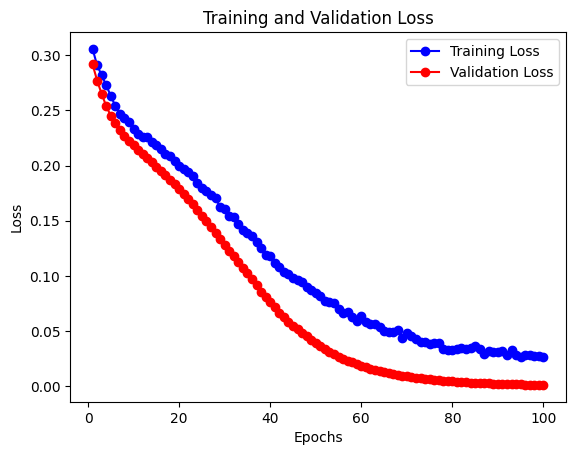

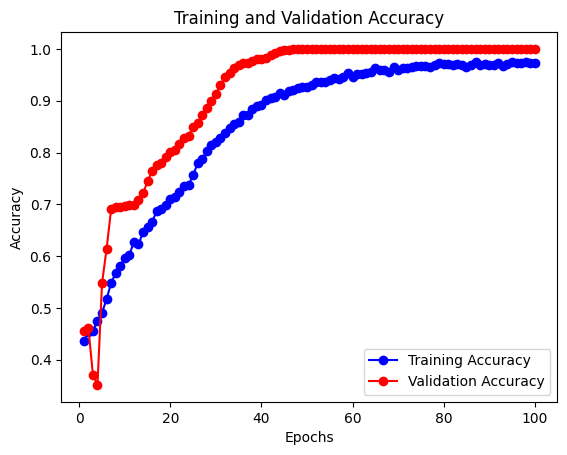

In [17]:
model = tf.keras.Sequential([
    tf.keras.layers.Dense(4, input_shape=(4,), activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss='mse',
    metrics=['accuracy']
)

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_val, y_val), callbacks=[early_stop])

train_loss = history.history['loss']
val_loss = history.history['val_loss']

train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

epochs = range(1, len(train_loss) + 1)

plt.plot(epochs, train_loss, 'bo-', label='Training Loss')
plt.plot(epochs, val_loss, 'ro-', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.plot(epochs, train_accuracy, 'bo-', label='Training Accuracy')
plt.plot(epochs, val_accuracy, 'ro-', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

Test model with random number and return Normal or Stunting

In [24]:
import random

Age = random.randint(1,5)
Gender = random.randint(0,1)
Height = round(random.uniform(69.0, 124), 2) if Gender == 0 else round(random.uniform(66.0, 124), 2)
Weight = round(random.uniform(6.9, 27.9), 2) if Gender == 0 else round(random.uniform(6.3, 29.5), 2)

test_data = np.array([[Age, Gender, Height, Weight]])

scaled_test = scaler.transform(test_data)

predict = model.predict(scaled_test)

result = "Normal" if predict[0,0] <= 0.5 else "Stunting"

print(f"Age\t : {Age} years old\nGender\t : {'Boy' if Gender == 0 else 'Girl'}\nHeight\t : {Height} cm\nWeight\t : {Weight} kg\nCategory : {result} ({predict})")

1/1 [==============================] - 0s 28ms/step
Age	 : 4 years old
Gender	 : Girl
Height	 : 97.57 cm
Weight	 : 27.06 kg
Category : Normal ([[9.156047e-19]])


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


In [25]:
model.save('model.keras')